In [32]:
# import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

# Reflect Tables into SQLAlchemy ORM

In [33]:
# define engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)

# identify columns
inspector = inspect(engine)
inspector.get_table_names()

print("measurement columns")
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print("------------")
print("station columns")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

measurement columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
station columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
# display sample contents
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [36]:
# determine highest date
session.query(func.max(Measurement.date)).all()

[('2017-08-23')]

In [37]:
# query for the last 12 months of precipitation data
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True, )
df.sort_values('date')
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


# Exploratory Climate Analysis

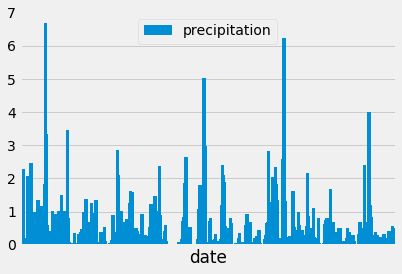

In [38]:
#plot results
df.plot.bar(width=20)
plt.legend(loc="upper center")
plt.xticks([])
plt.grid(True)
plt.show()

In [39]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [40]:
# Design a query to show how many stations are available in this dataset
results = session.query(Measurement.station).\
    group_by(Measurement.station).all()
print(len(results))
results

9


[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [41]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
results = (session.query(
                        func.min(Measurement.tobs),
                        func.max(Measurement.tobs),
                        func.avg(Measurement.tobs))
           .filter(Measurement.station == 'USC00519281').all())

results

[(54.0, 85.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

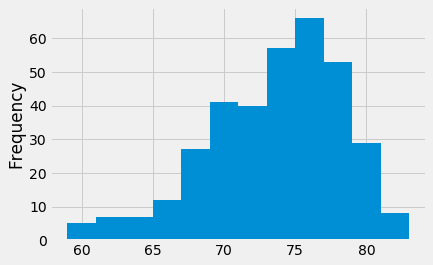

In [43]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = (session.query(
    Measurement.tobs)
.filter(Measurement.date >= '2016-08-23')
.filter(Measurement.station == 'USC00519281').all())

hgraph = []
for result in results:
    hgraph.append(result[0])

plt.ylabel('Frequency')
plt.hist(hgraph, bins=12, label="tobs")
plt.show

In [44]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """ 
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
for temp in (calc_temps('2017-04-01', '2017-04-15')):
    mintemp = temp[0]
    avgtemp = temp[1]
    maxtemp = temp[2]
print(mintemp, avgtemp, maxtemp)

67.0 74.47368421052632 82.0


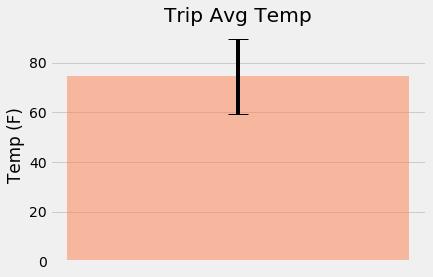

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = [maxtemp - mintemp]
x_pos = np.arange(1)

fig, ax = plt.subplots()
ax.bar(1, avgtemp, yerr=error, align='center', alpha=0.5, ecolor='black', color='coral', capsize=10)
ax.set_ylabel('Temp (F)')
ax.set_xticks(x_pos)
ax.set_title('Trip Avg Temp')
plt.show()

In [46]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = (session.query(
    Measurement.station,
    func.sum(Measurement.prcp))
.filter(Measurement.date >= '2017-04-01')
.filter(Measurement.date <= '2017-04-15')
.group_by(Measurement.station)
.order_by(func.sum(Measurement.prcp).desc()).all())

for result in results:
    stationcode = result[0]
    totalprcp = result[1]
    details = (session.query(
    Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)
           .filter(Station.station == stationcode).all())
    print(details, totalprcp)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)] 5.75
[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)] 4.14
[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)] 1.64
[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)] 0.8999999999999999
[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)] 0.36
[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)] 0.27
[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)] 0.0
